Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas - Otimizador Adam

Neste exercício vamos treinar uma rede MLP com o algoritimo backpropagation utilizando o otimizador Adam para a solução do problema das meias luas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [2]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

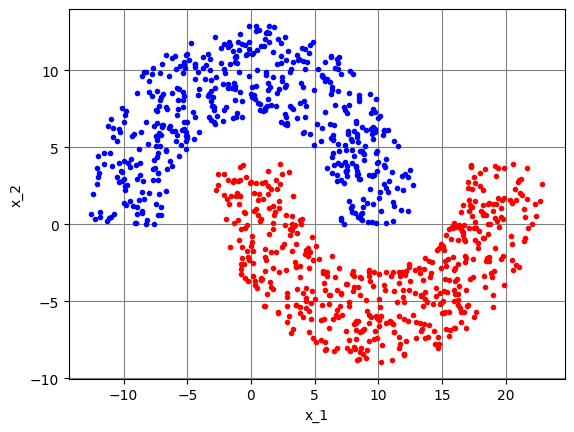

In [3]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [4]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo Adam, considerando a função de ativação $f(x) = \textnormal{tanh}(x)$ com derivada $f'(x) = 1 - \textnormal{tanh}^2(x)$ e função custo do MSE, como feito no exercício MLP 3.

Para definir a estrutura da rede, utilize uma entrada chamada `Nn` contendo o número de entradas da rede, seguido do número de neurônios de cada camada. Por exemplo: `Nn = [2, 3, 2, 1]` representa uma rede com duas entradas, duas camadas ocultas com 3 e 2 neurônios, respectivamente e um único neurônio na camada de saída.

Considere a seguinte assinatura para a função (note as entradas adicionais referentes aos hiperparâmetros do Adam):

```python
def redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    beta1, beta2: fatores de esquecimento do otimizador Adam
                  (e.g., beta1 = beta2 = 0.99)
    epsilon: constante para evitar divisão por zero no Adam
             (e.g. epsilon = 1e-4)
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente considerando a arquitetura `Nn = [2, 3, 5, 5, 2, 1]`. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [7]:
def redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0, beta1=0.99, beta2=0.99, epsilon=1e-4):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    beta1, beta2: fatores de esquecimento do otimizador Adam
                  (e.g., beta1 = beta2 = 0.99)
    epsilon: constante para evitar divisão por zero no Adam
             (e.g. epsilon = 1e-4)
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
   # --- 1. Inicialização ---

    # Número de camadas (exceto de entrada)
    L = len(Nn) - 1

    # Inicializa o vetor de custo MSE
    J_MSE = np.zeros(Ne)

    # Copia os pesos iniciais W0 para não modificar o original
    W = np.copy(W0)

    # Inicializa os estimadores de momento do Adam
    V = np.zeros_like(W)   # V: 1º momento (média dos gradientes)
    S = np.zeros_like(W)   # S: 2º momento (média dos gradientes ao quadrado)

    # Contador de passos (mini-batches) para a correção de viés do Adam
    t = 0

    # Loop para as épocas
    for k in range(Ne):

        # Embaralha os dados de treinamento a cada época e separa-os
        indices = np.random.permutation(Nt)
        x_shuffled = x[indices]
        d_shuffled = d[indices]

        # Inicializa o erro acumulado da época
        J_epoca = 0

        # Calcula o número de mini-batches
        Nmb = Nt // Nb

        # Loop para os mini-batches
        for l in range(Nmb):

            # Incrementa o contador de passos do Adam
            t = t + 1

            # Seleciona os dados do mini-batch
            inicio = l * Nb
            final = (l + 1) * Nb
            x_batch = x_shuffled[inicio:final]
            d_batch = d_shuffled[inicio:final]

            # Inicializa o gradiente acumulado para o mini-batch
            Delta_W_batch = np.zeros_like(W)

            # Loop para as amostras
            for n in range(Nb):

                # Pega a n-ésima amostra do batch
                x_n = x_batch[n]
                d_n = d_batch[n]

                # Listas para armazenar saídas (y) e potencias (v) de cada camada
                y_camadas = [None] * (L + 1)
                v_camadas = [None] * L

                # Cálculo progressivo

                # Camada de entrada (j=0) - Adiciona o bias
                y_camadas[0] = np.append(x_n, 1)

                for j in range(L):

                    # Seleciona os pesos para a camada j
                    W_j = W[0:Nn[j+1], 0:Nn[j]+1, j]

                    # Potencial de ativação (campo local induzido)
                    v_camadas[j] = W_j @ y_camadas[j] # Combinador linear

                    # Saída da camada j (ativação tangente hiperbólica)
                    y_out_j = np.tanh(v_camadas[j])

                    # Adiciona o bias para a próxima camada (exceto na camada de saída)
                    if j < L - 1:
                        y_camadas[j+1] = np.append(y_out_j, 1)
                    else:
                        y_camadas[j+1] = y_out_j # Saída final

                # Cálculo do erro
                y_final = y_camadas[L]
                e = d_n - y_final

                # Acumula o erro quadrático da época
                J_epoca += np.sum(e**2)

                # Cálculo regressivo

                # Lista para armazenar os gradientes locais (deltas)
                deltas = [None] * L

                # Camada de Saída (j = L-1)
                # Derivada da tanh: phi'(v) = 1 - tanh(v)^2 = 1 - y^2
                phi_prime_L = 1 - y_final**2
                # Gradiente local: delta = e * phi'(v)
                deltas[L-1] = e * phi_prime_L

                # Camadas Ocultas (j = L-2 ... 0)
                for j in reversed(range(L - 1)):

                    # Pesos da camada j+1 (camada à frente)
                    W_jplus1 = W[0:Nn[j+2], 0:Nn[j+1]+1, j+1]

                    # Remove a coluna de pesos do bias
                    W_jplus1_nobias = W_jplus1[:, 0:Nn[j+1]]

                    # Saída da camada j+1 (sem o bias)
                    y_jplus1_nobias = y_camadas[j+1][0:Nn[j+1]]

                    # Derivada da ativação da camada j
                    phi_prime_j = 1 - y_jplus1_nobias**2

                    # Propagação do gradiente local
                    deltas[j] = (W_jplus1_nobias.T @ deltas[j+1]) * phi_prime_j

                # Gradienetes para o Mini-Batch
                for j in range(L):
                    delta_j = deltas[j]
                    y_j = y_camadas[j] # Saída da camada anterior (com bias)

                    # Gradiente da amostra n: Delta_W_j = delta_j * y_j^T
                    Delta_W_j_n = np.outer(delta_j, y_j)

                    # Acumula o gradiente no tensor do mini-batch
                    Delta_W_batch[0:Nn[j+1], 0:Nn[j]+1, j] += Delta_W_j_n

            # Atualização de pesos segundo otimizador Adam

            # Média dos gradientes do mini-batch
            # g é o gradiente (equivalente a Delta_delta(n) nas fórmulas do Adam)
            g = Delta_W_batch / Nb

            # 1. Atualiza 1º momento (média móvel dos gradientes)
            V = beta1 * V + (1 - beta1) * g

            # 2. Atualiza 2º momento (média móvel dos gradientes ao quadrado)
            S = beta2 * S + (1 - beta2) * (g**2)

            # 3. Correção de viés
            V_corr = V / (1 - beta1**t)
            S_corr = S / (1 - beta2**t)

            # 4. Atualização final dos pesos
            # W = W + eta * V_corr / (sqrt(S_corr) + epsilon)
            W += eta * V_corr / (np.sqrt(S_corr) + epsilon)

        # Calcula o MSE da época (Erro Quadrático Médio por amostra)
        J_MSE[k] = J_epoca / Nt

    # Retorna custo quadrático médio e pesos do modelo.
    return J_MSE, W

In [17]:
# Parâmetros
Nn = [x.shape[1], 5, 5, 2, 1] # Arquitetura da rede [Entradas, Camada 1, Camada 2, Saída]
eta = 0.001                # Taxa de aprendizado
Nt = x.shape[0]            # Número de dados de treinamento
Nb = 50                    # Tamanho do mini-batch
Ne = 2000                  # Número de épocas
L = len(Nn) - 1            # Número de camadas de pesos
beta1 = 0.99
beta2 = 0.99
epsilon = 1e-4

# Inicialização dos pesos
max_n = np.max(Nn)
np.random.seed(42)
# Cria o tensor 3D de pesos
W0 = np.random.randn(max_n, max_n + 1, L)

# Utiliza a iniciação de Xavier/Glorot que ajuda a evitar mínimos locais
for l in range(L):
    n_in = Nn[l]
    n_out = Nn[l+1]

    lim = np.sqrt(6 / (n_in + n_out))
    # Redefine os pesos da fatia
    W0[:n_out, :(n_in + 1), l] = np.random.uniform(-lim, lim, (n_out, n_in + 1))


print("Iniciando o treinamento da rede")
J_MSE, W_final = redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0,
                              beta1=beta1, beta2=beta2, epsilon=epsilon)

print("Treinamento concluído.")
print(f"Custo (MSE) final após {Ne} épocas: {J_MSE[-1]:.6f}")


Iniciando o treinamento da rede
Treinamento concluído.
Custo (MSE) final após 2000 épocas: 0.000000


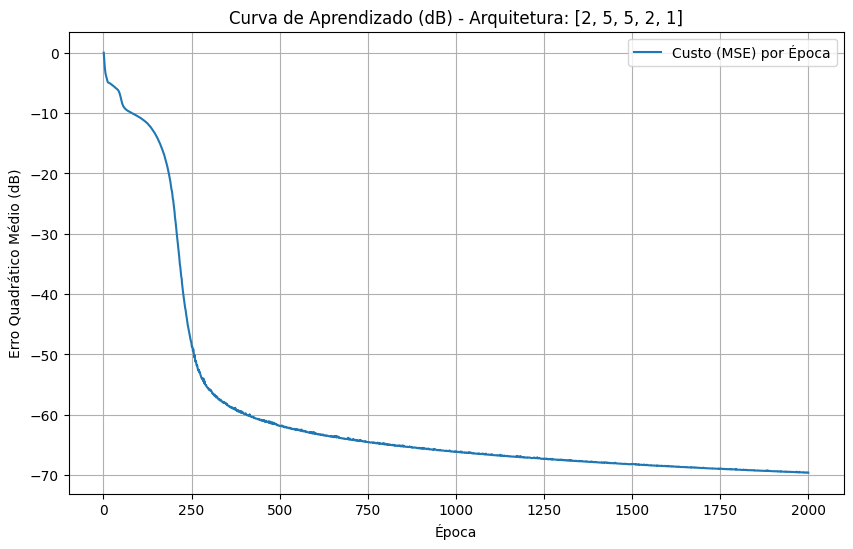

In [18]:
# Curva de aprendizado (em decibéis)
J_MSE_dB = 10 * np.log10(np.array(J_MSE))

plt.figure(figsize=(10, 6))
plt.plot(range(1, Ne + 1), J_MSE_dB, label='Custo (MSE) por Época')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio (dB)')
plt.title(f'Curva de Aprendizado (dB) - Arquitetura: {Nn}')
plt.grid(True)
plt.legend()
plt.show()

# Exercício 2

Utilizando os seguintes dados de teste:

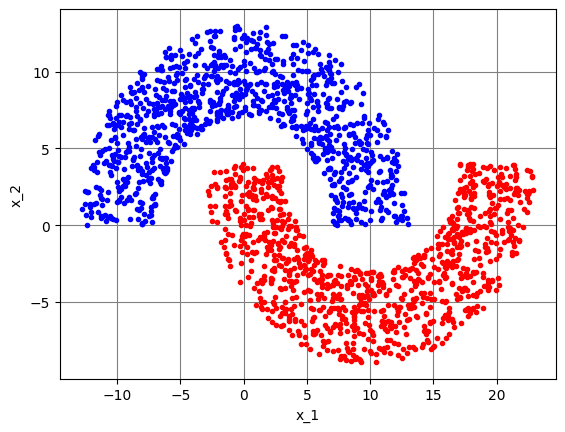

In [19]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura (note que pode ser usada a mesma função de teste implementada no exercício MLP 3):

``` python
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, considerando a arquitetura `Nn = [2, 3, 5, 5, 2, 1]`, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

Por fim, compare o resultado obtido com essa arquitetura considerando a rede MLP treinada com gradiente descendente, implementada no exercício MLP 3.

## Resolução

In [21]:
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
    x_bias = np.hstack((x, np.ones((Nteste, 1))))

    L = len(Nn) - 1 # Número de camadas

    # Dicionários para armazenar as saídas
    V = {}           # Potencial de ativação (v)
    Y = {}           # Saída de ativação (y)
    Y_bias = {}      # Saída com bias adicionado (y_com_bias)

    Y_bias[0] = x_bias.T

    # Cálculo progressivo
    for i in range(1, L + 1):
      l_idx = i - 1 # Índice da camada (0 a L-1)

      # Dimensões da matriz de pesos para esta camada
      n_in_com_bias = Nn[l_idx] + 1
      n_out = Nn[i]

      # Pega a matriz de pesos
      Wi = W[:n_out, :n_in_com_bias, l_idx]

      # Campo local induzido (v = W * y_anterior)
      V[i] = Wi @ Y_bias[i-1]

      # Saída de ativação (y = tanh(v))
      Y[i] = np.tanh(V[i])

      # Adiciona o bias para a próxima camada (exceto na última)
      if i < L:
        Y_bias[i] = np.vstack((Y[i], np.ones((1, Nteste))))

    # A saída final da rede é a ativação da última camada (sem bias)
    y = Y[L]

    # Cálculo do Custo (MSE)
    emb = d.T - y
    J_MSE = np.mean(emb**2)

    return J_MSE, y


In [22]:
# Usa os dados de teste para testar o modelo treinado anteriormente
J_teste, y_teste = redeMLP_teste(xteste, dteste, W_final, Nn, Nteste)

# Taxa de erro
y_teste = np.sign(y_teste.T)

acertos = np.sum(y_teste == dteste)
taxa_erro = (1.0 - acertos / Nteste) * 100

print(f"Taxa de erro: {taxa_erro:.2f}%")

Taxa de erro: 0.00%


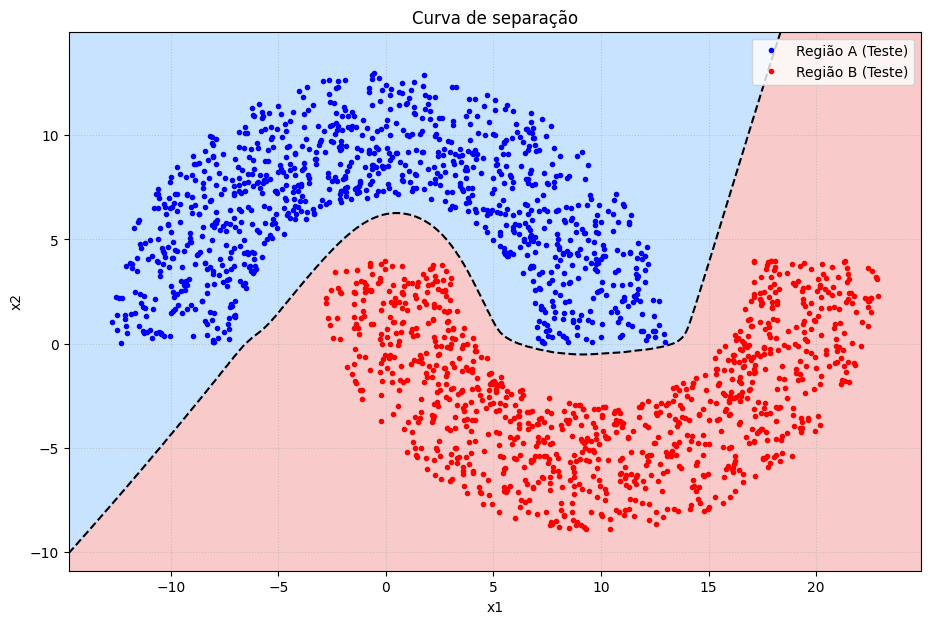

In [23]:
# Curva de separação

x1_min, x1_max = xteste[:, 0].min() - 2, xteste[:, 0].max() + 2
x2_min, x2_max = xteste[:, 1].min() - 2, xteste[:, 1].max() + 2

xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                     np.linspace(x2_min, x2_max, 200))

grid_data = np.c_[xx.ravel(), yy.ravel()]
Nt_grid = grid_data.shape[0]

x_bias_grid = np.hstack((grid_data, np.ones((Nt_grid, 1))))

L = len(Nn) - 1
Y = {}
Y_bias = {}

Y_bias[0] = x_bias_grid.T

for i in range(1, L + 1):
  l_idx = i - 1

  n_in = Nn[l_idx] + 1
  n_out = Nn[i]

  Wi = W_final[:n_out, :n_in, l_idx]

  V = Wi @ Y_bias[i-1]
  Y[i] = np.tanh(V)

  if i < L:
    Y_bias[i] = np.vstack((Y[i], np.ones((1, Nt_grid))))

Z = Y[L]

Z = Z.reshape(xx.shape)

plt.figure(figsize=(11, 7))

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['#F8BDBD', '#BADCFF'], alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], colors='black', linestyles='--')

pontosA = xteste[dteste.ravel() == 1]
plt.plot(pontosA[:, 0], pontosA[:, 1], 'b.', label='Região A (Teste)')

pontosB = xteste[dteste.ravel() == -1]
plt.plot(pontosB[:, 0], pontosB[:, 1], 'r.', label='Região B (Teste)')

plt.title('Curva de separação')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()
